In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import hdbscan

from sklearn.datasets import load_digits
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.datasets import fetch_openml

from sklearn.decomposition import PCA
from sklearn.utils import resample
from tensorflow.keras.datasets.fashion_mnist import load_data

#Import all the algorithms
from umap import UMAP
from sklearn.manifold import TSNE
from openTSNE import TSNE as OpenTSNE
from tqdm import tqdm

import time
%matplotlib inline

In [57]:
sns.set(context='paper', font='Arial', font_scale=1.3, rc={'figure.figsize':(18,12)})
sns.set_style("white")

In [3]:
fashion = fetch_openml('Fashion-MNIST', version=1)
X_f = fashion.data
y_f = fashion.target.astype('int')

In [4]:
#Methods
tsne_random_init = OpenTSNE(initialization='random', random_state=42)
tsne_pca_init = OpenTSNE(random_state=42)
# tsne_pca_init_lr = OpenTSNE(perplexity=X_d.shape[0]/100, learning_rate=X_d.shape[0]/12)
umap_random_init = UMAP(n_neighbors=30, min_dist=0, init='random',random_state=42)
umap_le_init = UMAP(n_neighbors=30, min_dist=0, random_state=42)

In [5]:
%%time
c_embedding_u_r = umap_random_init.fit_transform(X_f)
c_embedding_u_le = umap_le_init.fit_transform(X_f)

CPU times: user 5min 14s, sys: 7.49 s, total: 5min 21s
Wall time: 2min 16s


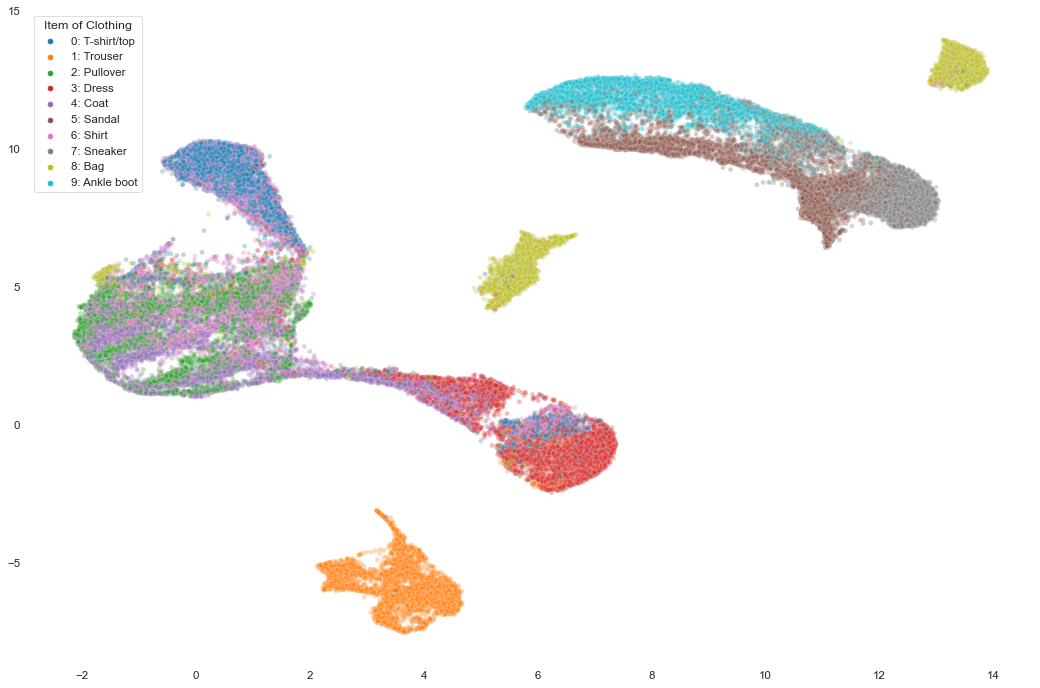

In [71]:
random_cluster = sns.scatterplot(
    x=c_embedding_u_r[:,0], y=c_embedding_u_r[:,1],
    hue=y_f,
    palette=sns.color_palette("tab10", 10),
    data=X_f,
    legend="full",
    alpha=0.3
)
sns.despine(left=True, bottom=True, right=True, top=True)
leg = random_cluster.legend()
leg.set_title("Item of Clothing")
legend_labels = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
for t, l in zip(leg.texts, legend_labels): t.set_text(l)
random_cluster.figure.savefig("clustering/Fashion/RandomUMAPCluster.jpg")

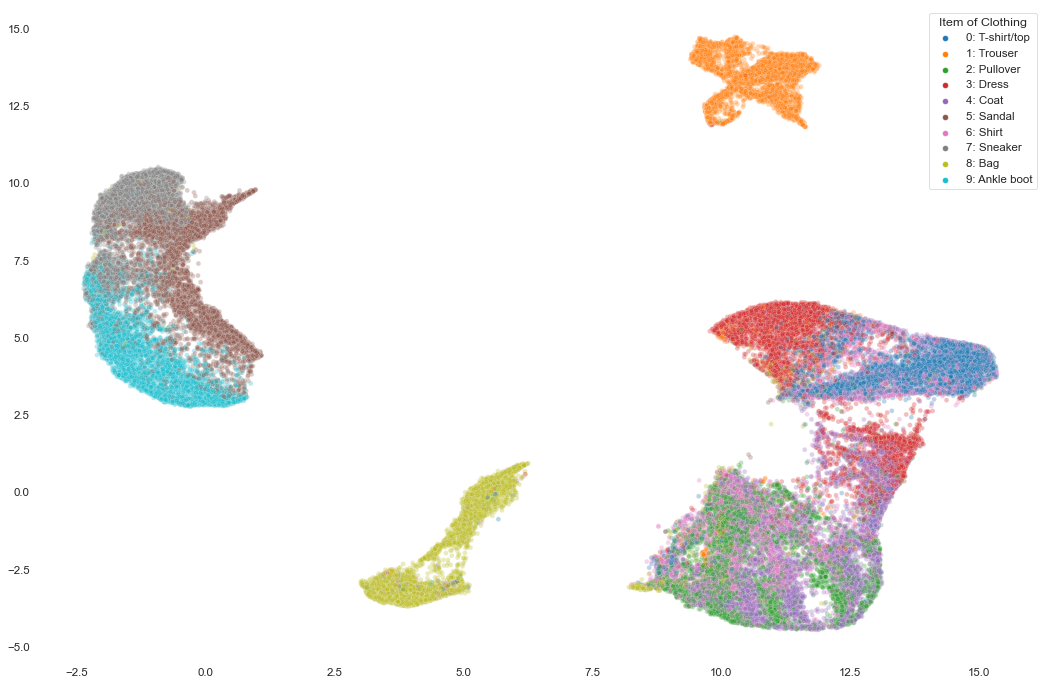

In [70]:
le_umap_plot = sns.scatterplot(
    x=c_embedding_u_le[:,0], y=c_embedding_u_le[:,1],
    hue=y_f,
    palette=sns.color_palette("tab10", 10),
    data=X_f,
    legend="full",
    alpha=0.3
)
sns.despine(left=True, bottom=True, right=True, top=True)
leg = le_umap_plot.legend()
leg.set_title("Item of Clothing")
legend_labels = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
for t, l in zip(leg.texts, legend_labels): t.set_text(l)
le_umap_plot.figure.savefig("clustering/Fashion/LeUMAPCluster.jpg")

In [18]:
labels_u_le_d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(c_embedding_u_le)

labels_u_r_d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(c_embedding_u_r)

In [19]:
print(adjusted_rand_score(y_f, labels_u_le_d), adjusted_mutual_info_score(y_f, labels_u_le_d))
print(adjusted_rand_score(y_f, labels_u_r_d), adjusted_mutual_info_score(y_f, labels_u_r_d))

0.3973326247352151 0.641915134606994
0.34416994872435147 0.6221493071578326


In [20]:
clustered_u_le_d = (labels_u_le_d >= 0)
print(adjusted_rand_score(y_f[clustered_u_le_d], labels_u_le_d[clustered_u_le_d]),
      adjusted_mutual_info_score(y_f[clustered_u_le_d], labels_u_le_d[clustered_u_le_d]))
clustered_u_r_d = (labels_u_r_d >= 0)
print(adjusted_rand_score(y_f[clustered_u_r_d], labels_u_r_d[clustered_u_r_d]),
      adjusted_mutual_info_score(y_f[clustered_u_r_d], labels_u_r_d[clustered_u_r_d]))

0.39774714146575024 0.6434849519032694
0.34517006029846053 0.6273738848392972


In [21]:
print(np.sum(clustered_u_le_d) / X_f.shape[0])
print(np.sum(clustered_u_r_d) / X_f.shape[0])

0.9984571428571428
0.9957857142857143


In [22]:
pca = PCA()
PCA_d = pca.fit(X_f)

In [23]:
count_d = 0
var_d = 0
for i in range(len(PCA_d.explained_variance_ratio_)):
  var_d += PCA_d.explained_variance_ratio_[i]
  count_d += 1

  if var_d > 0.98:
    break
print(var_d, count_d)

0.9800380476986776 349


In [24]:
print(len(PCA_d.explained_variance_ratio_))

784


In [25]:
X_whitened = X_f - X_f.mean(axis=0)
U, s, V = np.linalg.svd(X_whitened, full_matrices=False)
X784 = np.dot(U, np.diag(s))[:,:784] #Caputer 98% of Variance using 349 first PCs

In [28]:
%%time
c_embedding_t_pca = tsne_pca_init.fit(X784)
c_embedding_t_r = tsne_random_init.fit(X784)

CPU times: user 10min 4s, sys: 14.8 s, total: 10min 18s
Wall time: 10min 1s


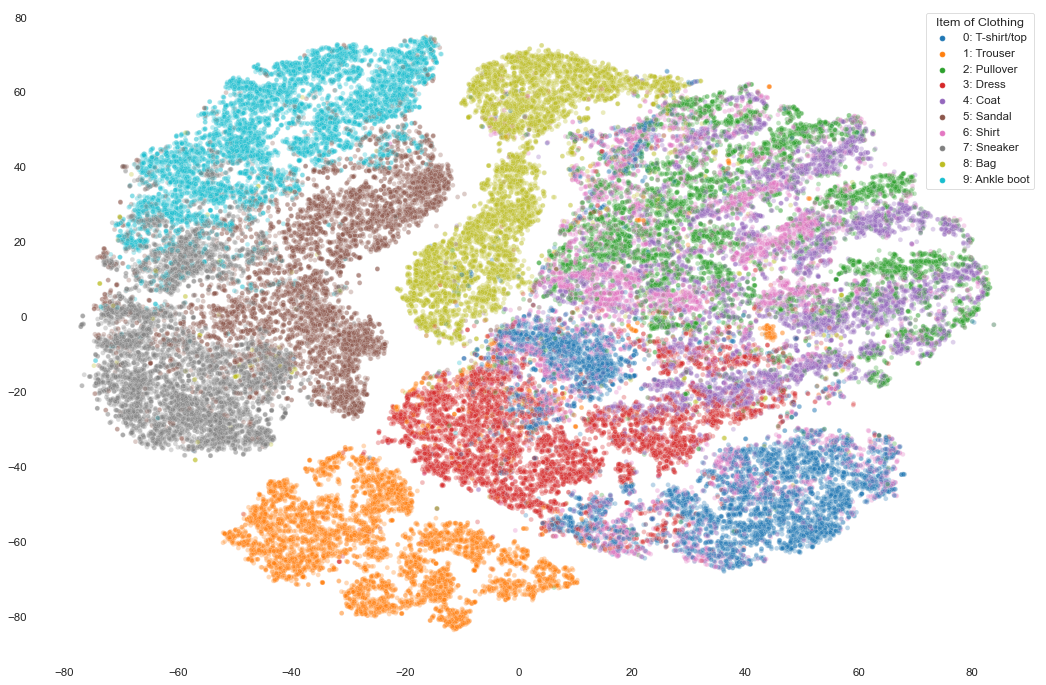

In [69]:
random_cluster = sns.scatterplot(
    x=c_embedding_t_pca[:,0], y=c_embedding_t_pca[:,1],
    hue=y_f,
    palette=sns.color_palette("tab10", 10),
    data=X_f,
    legend="full",
    alpha=0.3
)
sns.despine(left=True, bottom=True, right=True, top=True)
leg = random_cluster.legend()
leg.set_title("Item of Clothing")
legend_labels = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
for t, l in zip(leg.texts, legend_labels): t.set_text(l)
random_cluster.figure.savefig("clustering/Fashion/PcaTsneluster.jpg")

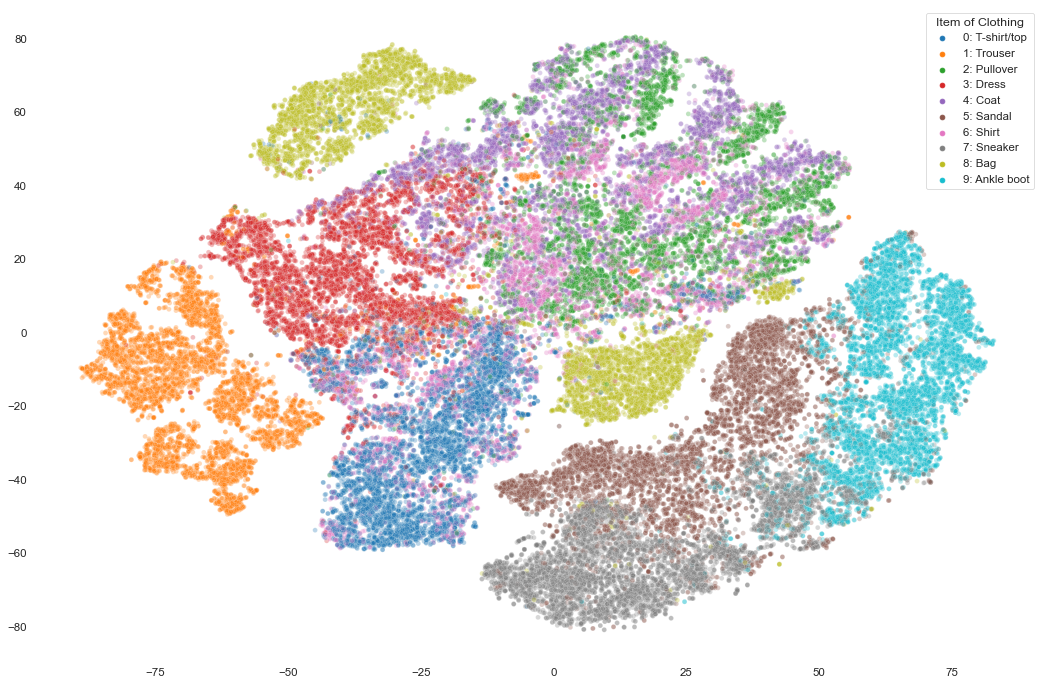

In [72]:
random_cluster_tsne = sns.scatterplot(
    x=c_embedding_t_r[:,0], y=c_embedding_t_r[:,1],
    hue=y_f,
    palette=sns.color_palette("tab10", 10),
    data=X_f,
    legend="full",
    alpha=0.3
)
sns.despine(left=True, bottom=True, right=True, top=True)
leg = random_cluster_tsne.legend()
leg.set_title("Item of Clothing")
legend_labels = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
for t, l in zip(leg.texts, legend_labels): t.set_text(l)
random_cluster_tsne.figure.savefig("clustering/Fashion/RandomTsneCluster.jpg")

In [33]:
%time embedding_2_tsne_pca = c_embedding_t_pca.optimize(n_iter=125, exaggeration=1, momentum=0.5)

CPU times: user 33.9 s, sys: 2.36 s, total: 36.2 s
Wall time: 36.3 s


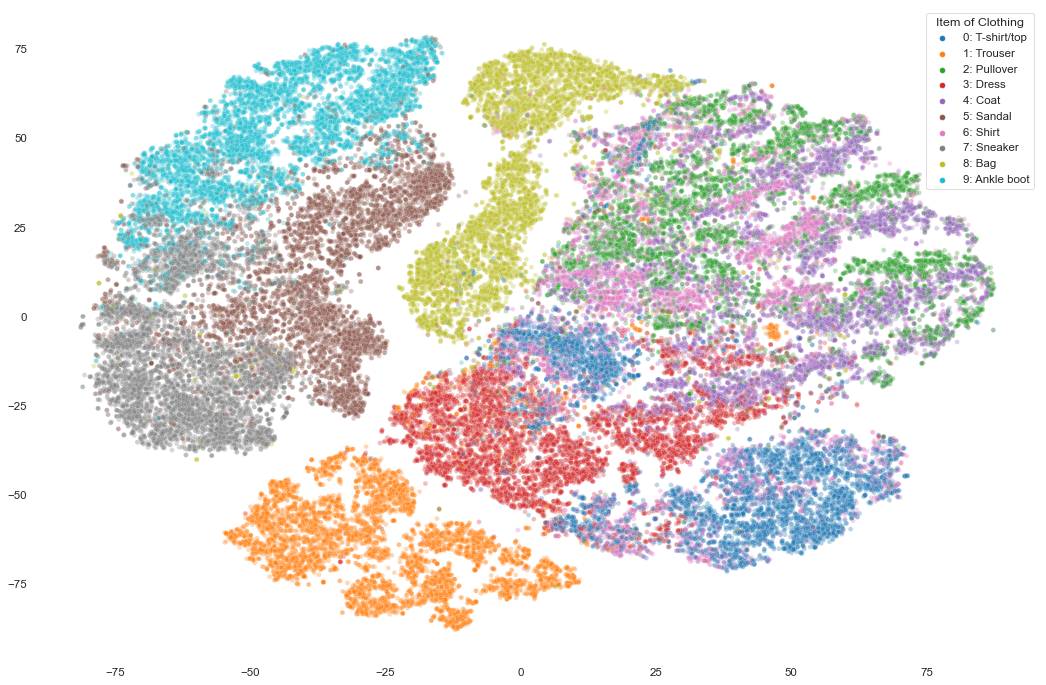

In [73]:
embedding_optim_1 = sns.scatterplot(
    x=embedding_2_tsne_pca[:,0], y=embedding_2_tsne_pca[:,1],
    hue=y_f,
    palette=sns.color_palette("tab10", 10),
    data=X_f,
    legend="full",
    alpha=0.3
)
sns.despine(left=True, bottom=True, right=True, top=True)
leg = embedding_optim_1.legend()
leg.set_title("Item of Clothing")
legend_labels = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
for t, l in zip(leg.texts, legend_labels): t.set_text(l)
embedding_optim_1.figure.savefig("clustering/Fashion/Exag1Iter125Momentum05.jpg")

CPU times: user 1min 8s, sys: 7.22 s, total: 1min 15s
Wall time: 1min 17s


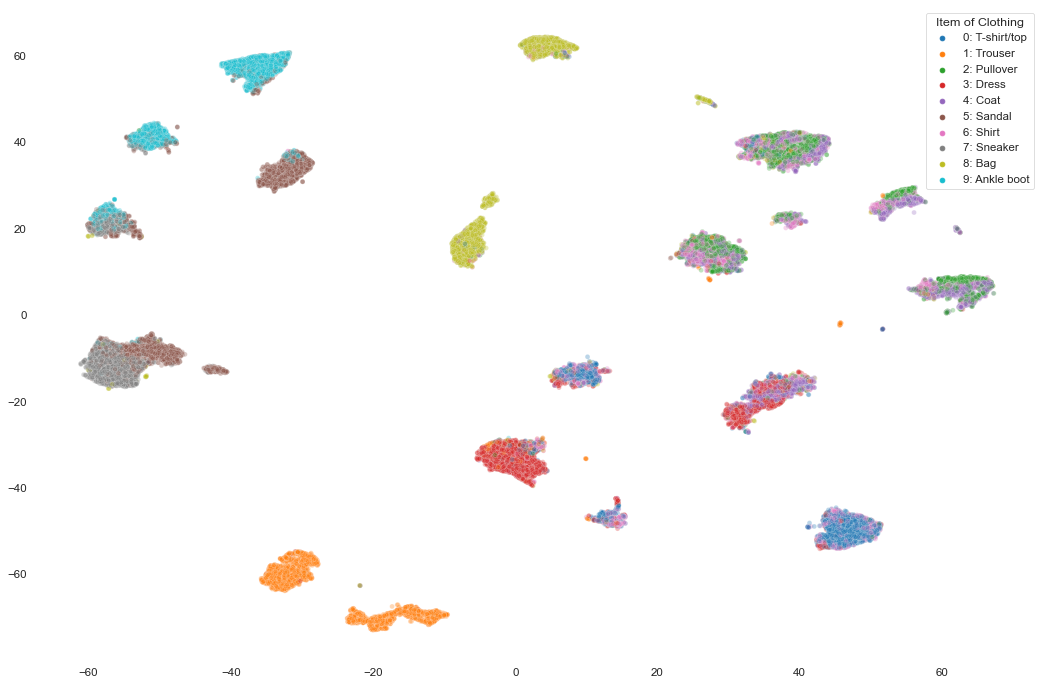

In [74]:
%time embedding_3_tsne_pca = embedding_2_tsne_pca.optimize(n_iter=250, exaggeration=3, momentum=0.8)
embedding_optim_2 = sns.scatterplot(
    x=embedding_3_tsne_pca[:,0], y=embedding_3_tsne_pca[:,1],
    hue=y_f,
    palette=sns.color_palette("tab10", 10),
    data=X_f,
    legend="full",
    alpha=0.3
)
sns.despine(left=True, bottom=True, right=True, top=True)
leg = embedding_optim_2.legend()
leg.set_title("Item of Clothing")
legend_labels = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
for t, l in zip(leg.texts, legend_labels): t.set_text(l)
embedding_optim_2.figure.savefig("clustering/Fashion/Exag3Iter250Momentum08.jpg")

In [36]:
labels_t_pca_d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(c_embedding_t_pca)

labels_t_r_d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(c_embedding_t_r)

In [37]:
print(adjusted_rand_score(y_f, labels_t_pca_d), adjusted_mutual_info_score(y_f, labels_t_pca_d))
print(adjusted_rand_score(y_f, labels_t_r_d), adjusted_mutual_info_score(y_f, labels_t_r_d))

-0.3108379089357463 0.5125575553034573
-0.28711580936685166 0.5546208797424926


/Users/idewa/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/Users/idewa/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))


In [38]:
clustered_t_pca_d = (labels_t_pca_d >= 0)
print(adjusted_rand_score(y_f[clustered_t_pca_d], labels_t_pca_d[clustered_t_pca_d]),
      adjusted_mutual_info_score(y_f[clustered_t_pca_d], labels_t_pca_d[clustered_t_pca_d]))
clustered_t_r_d = (labels_t_r_d >= 0)
print(adjusted_rand_score(y_f[clustered_t_r_d], labels_t_r_d[clustered_t_r_d]),
      adjusted_mutual_info_score(y_f[clustered_t_r_d], labels_t_r_d[clustered_t_r_d]))

-0.3049606766415066 0.5134852348359862
-0.2859579241899565 0.5558007711880818


/Users/idewa/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/Users/idewa/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))


In [39]:
print(np.sum(clustered_u_le_d) / X_f.shape[0])
print(np.sum(clustered_u_r_d) / X_f.shape[0])

0.9984571428571428
0.9957857142857143


In [40]:
labels_t_pca_d_3 = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(embedding_3_tsne_pca)

In [41]:
print(adjusted_rand_score(y_f, labels_t_pca_d_3), adjusted_mutual_info_score(y_f, labels_t_pca_d_3))

0.38778203296379593 0.5976739505785902


In [42]:
clustered_t_pca_d = (labels_t_pca_d_3 >= 0)
print(adjusted_rand_score(y_f[clustered_t_pca_d], labels_t_pca_d_3[clustered_t_pca_d]),
      adjusted_mutual_info_score(y_f[clustered_t_pca_d], labels_t_pca_d_3[clustered_t_pca_d]))

0.3878562553705914 0.5978264358692155


In [43]:
print(np.sum(clustered_t_pca_d) / X_f.shape[0])

0.9998571428571429


CPU times: user 1min 4s, sys: 7.13 s, total: 1min 12s
Wall time: 1min 12s


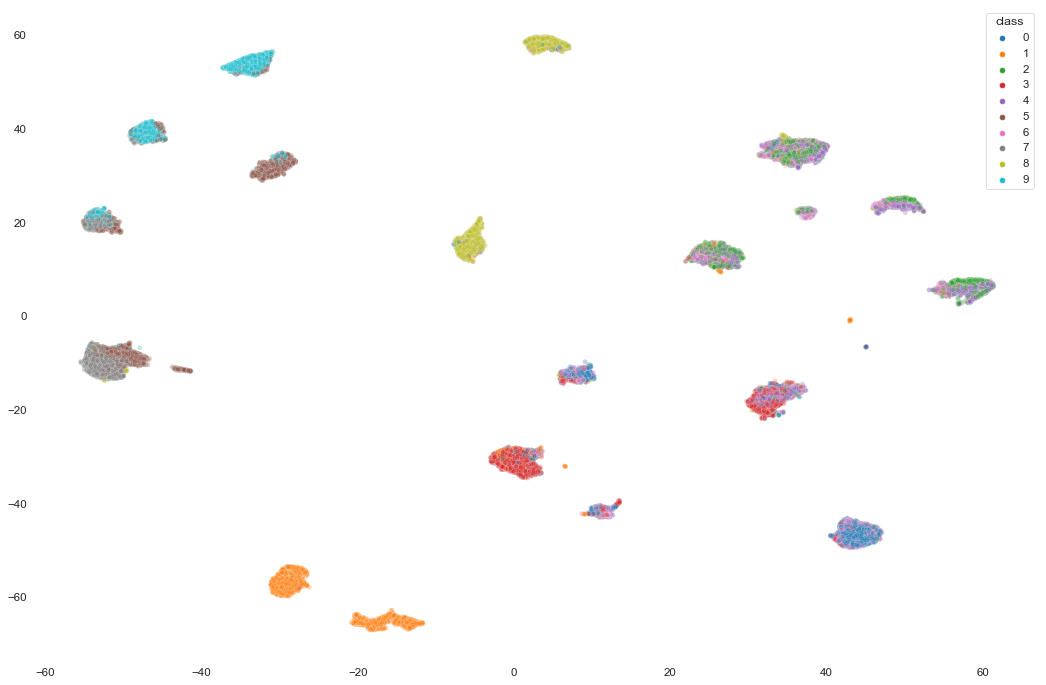

In [75]:
%time faster_exag_t_pca = c_embedding_t_pca.optimize(n_iter=250, exaggeration=4, momentum=0.8)

embedding_optim_3 = sns.scatterplot(
    x=faster_exag_t_pca[:,0], y=faster_exag_t_pca[:,1],
    hue=y_f,
    palette=sns.color_palette("tab10", 10),
    data=X_f,
    legend="full",
    alpha=0.3
)
sns.despine(left=True, bottom=True, right=True, top=True)
leg = embedding_optim_2.legend()
leg.set_title("Item of Clothing")
legend_labels = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
for t, l in zip(leg.texts, legend_labels): t.set_text(l)
embedding_optim_3.figure.savefig("clustering/Fashion/PrimaryExag3Iter250Momentum08.jpg")

In [77]:
%time faster_exag_t_pca_1 = faster_exag_t_pca.optimize(n_iter=125, exaggeration=1, momentum=0.5)

CPU times: user 26.1 s, sys: 1.65 s, total: 27.7 s
Wall time: 27.7 s


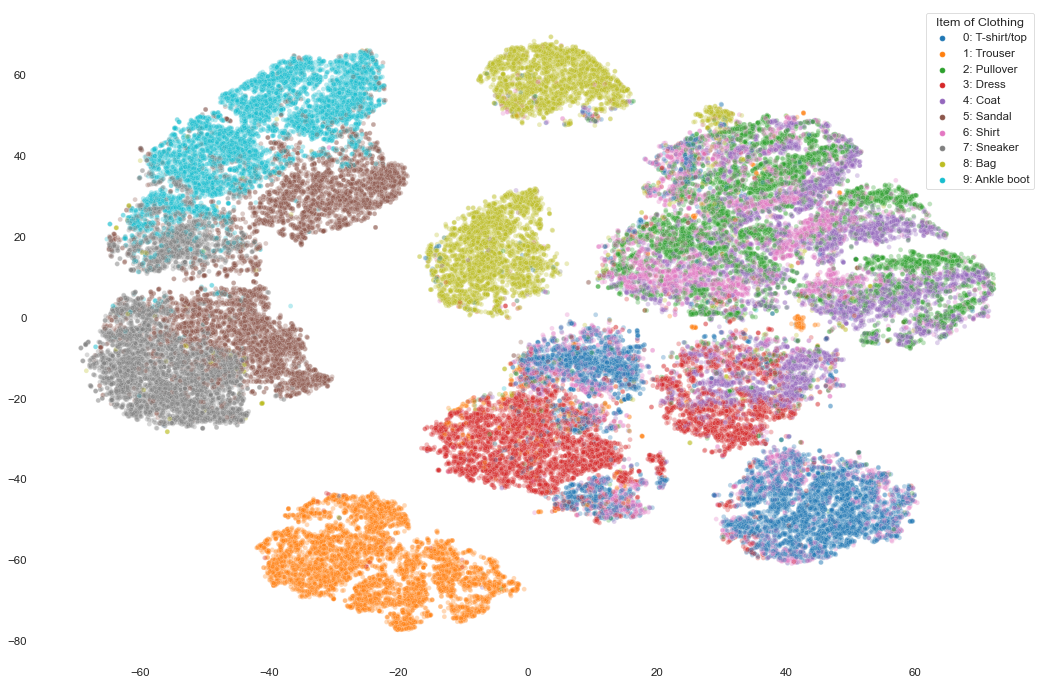

In [78]:
embedding_optim_4 = sns.scatterplot(
    x=faster_exag_t_pca_1[:,0], y=faster_exag_t_pca_1[:,1],
    hue=y_f,
    palette=sns.color_palette("tab10", 10),
    data=X_f,
    legend="full",
    alpha=0.3
)
sns.despine(left=True, bottom=True, right=True, top=True)

leg = embedding_optim_4.legend()
leg.set_title("Item of Clothing")
legend_labels = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
for t, l in zip(leg.texts, legend_labels): t.set_text(l)
embedding_optim_4.figure.savefig("clustering/Fashion/SubsequentExag1Iter750Momentum05.jpg")

In [79]:
labels_t_pca_optim = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(faster_exag_t_pca_1)

print(adjusted_rand_score(y_f, labels_t_pca_optim), adjusted_mutual_info_score(y_f, labels_t_pca_optim))

clustered_t_pca_d = (labels_t_pca_optim >= 0)
print(adjusted_rand_score(y_f[clustered_t_pca_d], labels_t_pca_optim[clustered_t_pca_d]),
      adjusted_mutual_info_score(y_f[clustered_t_pca_d], labels_t_pca_optim[clustered_t_pca_d]))

0.45058042218639166 0.643429395448654
0.45431848352529725 0.6522491727315173


In [48]:
print(np.sum(clustered_t_pca_d) / X_f.shape[0])

0.9998857142857143


In [80]:
%time exag_1 = c_embedding_t_pca.optimize(n_iter=250, exaggeration=4, momentum=0.2)

CPU times: user 1min 7s, sys: 6.12 s, total: 1min 13s
Wall time: 1min 13s


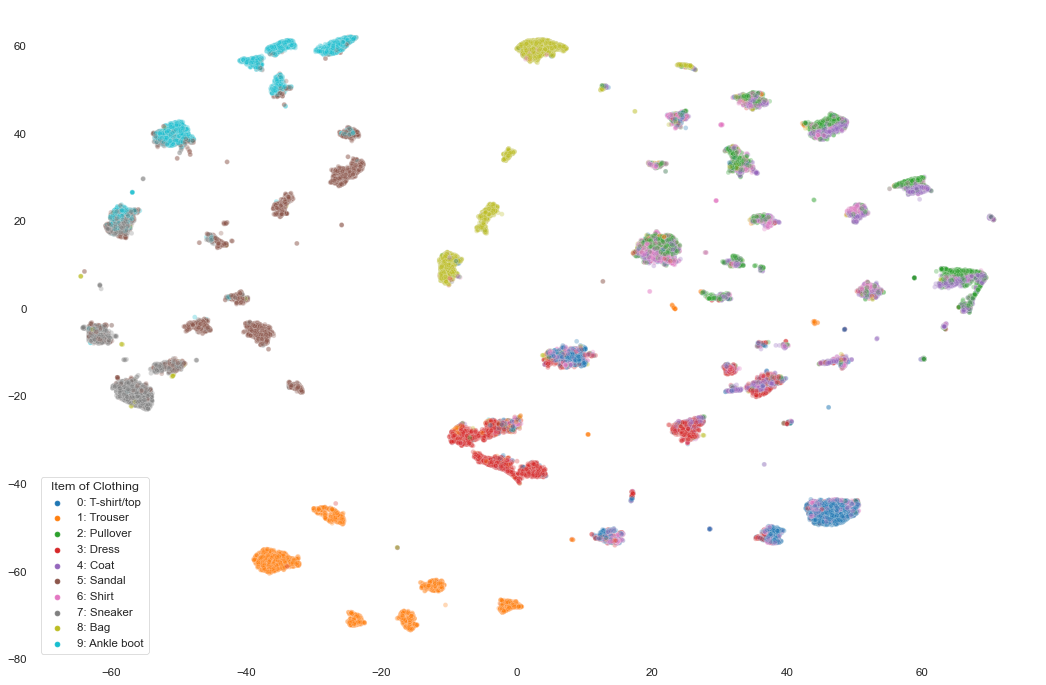

In [81]:
embedding_optim_5 = sns.scatterplot(
    x=exag_1[:,0], y=exag_1[:,1],
    hue=y_f,
    palette=sns.color_palette("tab10", 10),
    data=X_f,
    legend="full",
    alpha=0.3
)
sns.despine(left=True, bottom=True, right=True, top=True)

leg = embedding_optim_5.legend()
leg.set_title("Item of Clothing")
legend_labels = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
for t, l in zip(leg.texts, legend_labels): t.set_text(l)
embedding_optim_5.figure.savefig("clustering/Fashion/Exag4Iter200Momentum02.jpg")

In [99]:
%time exag_2 = exag_1.optimize(n_iter=750, exaggeration=4, momentum=0.8)

CPU times: user 4min 35s, sys: 29.2 s, total: 5min 5s
Wall time: 5min 7s


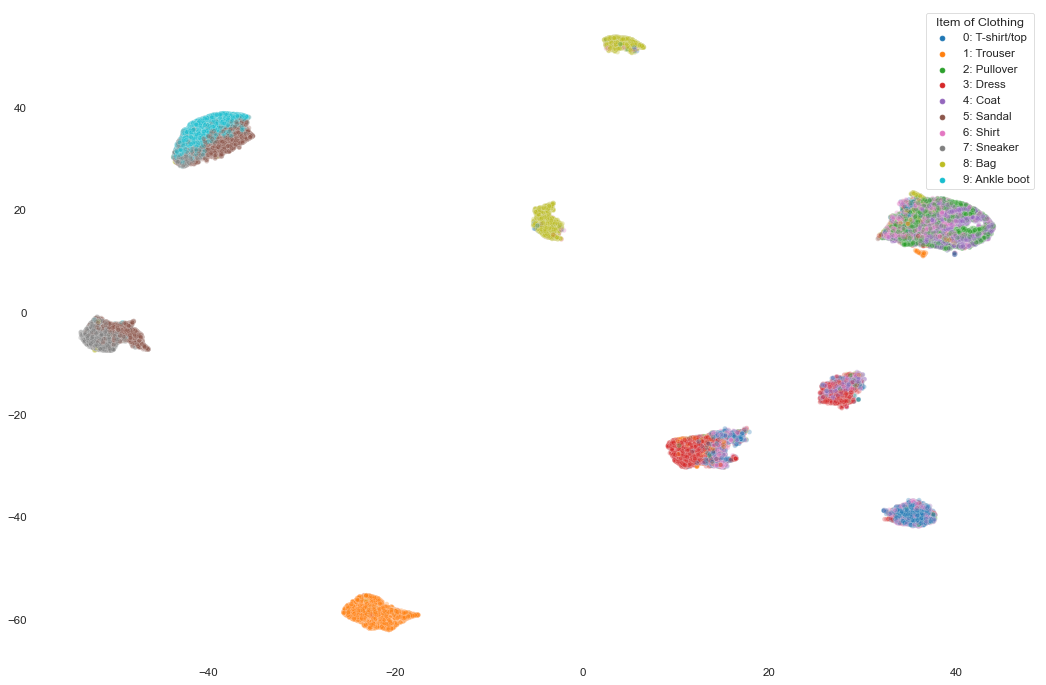

In [100]:
embedding_optim_6 = sns.scatterplot(
    x=exag_2[:,0], y=exag_2[:,1],
    hue=y_f,
    palette=sns.color_palette("tab10", 10),
    data=X_f,
    legend="full",
    alpha=0.3
)
sns.despine(left=True, bottom=True, right=True, top=True)

leg = embedding_optim_6.legend()
leg.set_title("Item of Clothing")
legend_labels = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
for t, l in zip(leg.texts, legend_labels): t.set_text(l)
embedding_optim_6.figure.savefig("clustering/Fashion/SubsequenttoExag1_3.jpg")

In [101]:
labels_t_pca_optim = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(exag_2)

print(adjusted_rand_score(y_f, labels_t_pca_optim), adjusted_mutual_info_score(y_f, labels_t_pca_optim))

clustered_t_pca_d = (labels_t_pca_optim >= 0)
print(adjusted_rand_score(y_f[clustered_t_pca_d], labels_t_pca_optim[clustered_t_pca_d]),
      adjusted_mutual_info_score(y_f[clustered_t_pca_d], labels_t_pca_optim[clustered_t_pca_d]))

0.447528750304858 0.6452187668107469
0.447528750304858 0.6452187668107469
